In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Helper Functions

In [5]:
def char_label_text(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

def word_label_text(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ' '.join([w_itos[i] for i in ints])

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

In [84]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

### 3x1

In [85]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
FOLDER = 'synth_words'
# char_csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

csv = pd.read_csv(CSV)
len(csv)

50000

In [86]:
seq_len = 45
stats = inception_stats
# stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))

### 3x2

In [8]:
fname = 'multi_synth_words_50000.csv' if device.type == 'cuda' else 'multi_synth_words.csv'
CSV = PATH/fname
FOLDER = 'multi_synth_words'

csv = pd.read_csv(CSV)
len(csv)

50000

In [9]:
seq_len = 45 #75
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

### Large (1000x1000)

In [8]:
CSV = PATH/'large_synth_words_50000.csv'
FOLDER = 'large_synth_words'

csv = pd.read_csv(CSV)
len(csv)

5000

In [9]:
seq_len = 45 #200
stats = (np.array([0.93186, 0.93186, 0.93186]), np.array([0.17579, 0.17579, 0.17579]))

### Word

In [10]:
w_itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

In [8]:
# 3x1
# W_CSV = PATH/'synth_word_ids.csv'
# FOLDER = 'synth_words'

# 3x2
# W_CSV = PATH/'multi_synth_word_ids.csv'
# FOLDER = 'multi_synth_words'

# large
W_CSV = PATH/'large_synth_word_ids_50000.csv'
FOLDER = 'large_synth_words'

w_csv = pd.read_csv(W_CSV)
len(w_csv)

50000

#### Only word testing

In [11]:
stats = inception_stats
itos = w_itos
CSV = W_CSV
csv = w_csv
seq_len = 40

### Get val_idxs

In [12]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

7500

### Calculate normalization stats

In [ ]:
means = []
stds  = []
for filename in os.listdir(PATH/FOLDER):
    im=Image.open(PATH/FOLDER/filename)
    img = np.array(im)
    means.append(img.mean((0,1)))
    stds.append(img.std((0,1)))
    im.close()
    
means = np.stack(means)
stds = np.stack(stds)

In [19]:
stats = (np.array(means.mean(0)/255), np.array(stds.mean(0)/255))
stats

(array([0.93186, 0.93186, 0.93186]), array([0.17579, 0.17579, 0.17579]))

### ModelData object

In [14]:
# sz=64
# bs=120

# sz = 128
# bs = 100

sz = 256
bs = 60

In [15]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

# stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
# resizes in the transforms
data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)
# loads in the data at full size

In [60]:
# this saves a bit of memory
# data = data.resize(512)

In [16]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

#### Verify dataset transforms

In [17]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
imgs = denorm(x)

In [17]:
# check image normalization
reshaped = x.permute(1,0,2,3).contiguous().view(3,-1)
trn_mean = reshaped.mean(1)
trn_std  = reshaped.std(1)
print(f"mean: {trn_mean}\nstd: {trn_std}")

mean: tensor([0.8003, 0.8003, 0.8003], device='cuda:0')
std: tensor([0.3654, 0.3654, 0.3654], device='cuda:0')


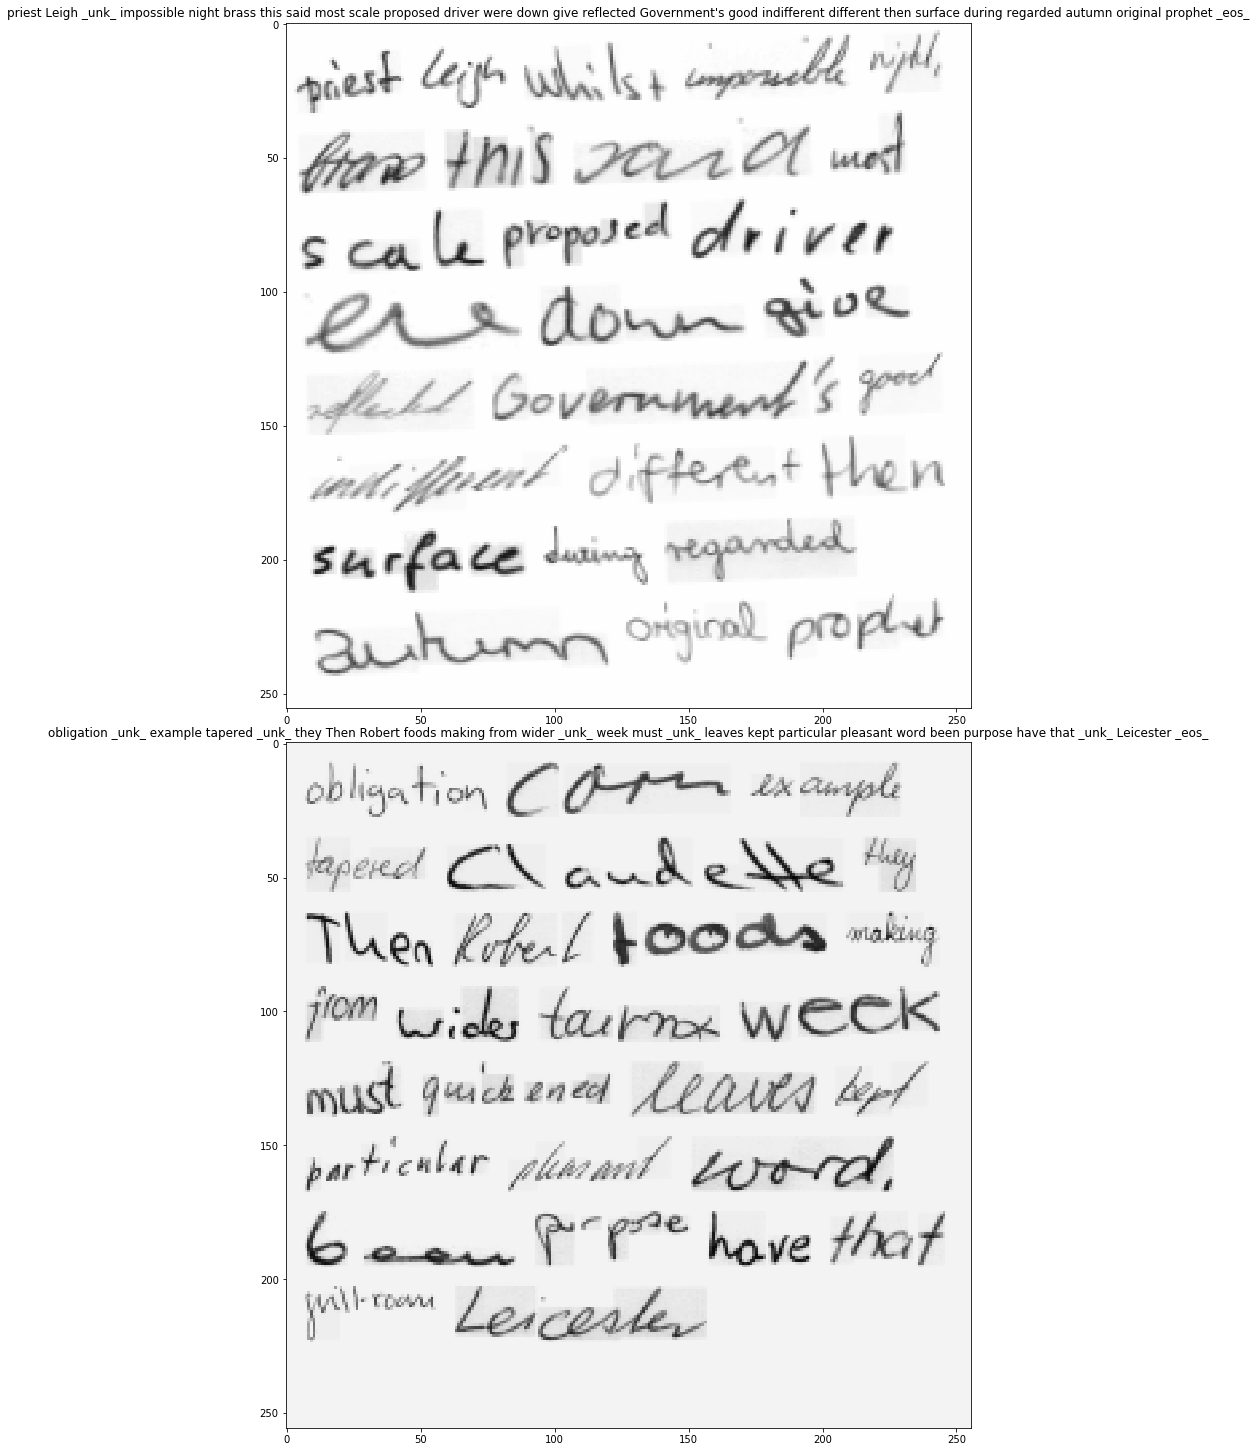

In [19]:
fig, axes = plt.subplots(2,1, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = word_label_text(y[i])
#     t = char_label_text(y[i])
    ax=show_img(imgs[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss and Metrics

In [20]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,vocab = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: target = target[:sl]  
#     if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.view(-1)
    pred = input.view(-1, vocab)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [21]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [22]:
def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = char_label_text(res[:,i])
        t = char_label_text(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_label_text(res[:,i])
        t = word_label_text(targs[i])
        error += wer(t,p)
    return error/bs

# Xception

In [23]:
class SeparableConv2d(nn.Module):
    def __init__(self,c_in,c_out,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        # depthwise conv - spatial conv performed independently over every channel of an input
        self.conv1 = nn.Conv2d(c_in,c_in,kernel_size,stride,padding,dilation,groups=c_in,bias=bias)
        # pointwise conv - regular 1x1 conv, projecting channels computed by depthwise conv onto new channel space
        self.pointwise = nn.Conv2d(c_in,c_out,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

In [24]:
class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x

In [25]:
# https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/xception.py

class XceptionBase(nn.Module):
    def __init__(self):
        super(XceptionBase, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, 2, 0, bias=False)      #32
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)    #16
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)    #8
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)    #4

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)   # 64: 4x4x728

#         self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)
#         self.conv3 = SeparableConv2d(1024,1536,3,1,1)
#         self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
#         self.conv4 = SeparableConv2d(1536,2048,3,1,1)
#         self.bn4 = nn.BatchNorm2d(2048)

#         self.fc = nn.Linear(2048, num_classes)

#         self.conv3 = SeparableConv2d(728, 1024, 3, 1, 1)
#         self.bn3 = nn.BatchNorm2d(1024)
        
        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
#         x = self.block12(x)

#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.relu(x)

#         x = self.conv4(x)
#         x = self.bn4(x)
        return x

In [119]:
# modified to replace resnet34 base in Arch

class XceptionBase(nn.Module):
    def __init__(self):
        super(XceptionBase, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, 3, 2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(8,16,3,bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        #do relu here

        self.block1=Block(16,32,2,2,start_with_relu=False,grow_first=True)    #16
        self.block2=Block(32,64,2,2,start_with_relu=True,grow_first=True)     #8
        self.block3=Block(64,128,2,2,start_with_relu=True,grow_first=True)    #4

        self.block4=Block(128,128,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(128,128,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(128,128,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(128,128,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(128,128,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(128,128,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(128,128,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(128,128,3,1,start_with_relu=True,grow_first=True)   # 64: 4x4x128; 256: 16x16x128

        self.conv3 = SeparableConv2d(128, 256, 3, 1, 1)
        self.bn3   = nn.BatchNorm2d(256)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        return x

In [26]:
class Net(nn.Module):
    def __init__(self, base, seq_len, vocab):
        super(Net, self).__init__()
        
        self.base = base
        self.conv = SeparableConv2d(728, 1024, 3, 1, 1)
        self.bn   = nn.BatchNorm2d(1024)
        self.drop = nn.Dropout2d(0.5)
        self.pool = nn.AdaptiveMaxPool1d(seq_len)
        self.fc   = nn.Linear(1024, vocab)

    def forward(self, input):
        x = self.base(input)
        x = self.drop(F.relu(self.bn(self.conv(x))))
        x = self.pool(x.flatten(2,3)).permute(0,2,1)
        x = self.fc(x)
        return x.permute(1,0,2).contiguous()   #sl,bs,vocab

In [27]:
base = XceptionBase()

# load pretrained model
zoo_model = torch.utils.model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth')
base.load_state_dict(zoo_model, strict=False)

In [28]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
net = Net(base, seq_len, len(itos))
# net = ConvnetBuilder(f, 0, 0, True, custom_head=head, xtra_cut=1).model
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate] #[char_error_rate]

In [67]:
# learn.save('Xception_pretrained')
learn.load('Xception_pretrained')

# Arch

In [ ]:
def ResnetBase(embed_size):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[embed_size]
    net = resnet34(True)
    modules = list(net.children())[:s]
    return nn.Sequential(*modules)

base = ResnetBase(256)

In [121]:
# modified for sz: 64

class Encoder(nn.Module):
    def __init__(self, base, embed_size, drop=0.5):
        super().__init__()

        self.base = base
#         self.linear0 = nn.Linear(728, embed_size)    # Xception base
         
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp).flatten(2, 3).permute(2, 0, 1)
#         features = self.linear0(features)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [99]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = self.drop(torch.tanh(w1e + w2h))        # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [100]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.5):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers, dropout=drop)

    def forward(self, context, hidden):
        out, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return out[-1]

In [101]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.5):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [122]:
class Net(nn.Module):
    def __init__(self, base, hidden_size, vocab_size, seq_len, n_layers=1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.encoder = Encoder(base, hidden_size)
        self.attn    = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        self.embed   = nn.Embedding(vocab_size, hidden_size)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.embed(dec_inp)
            
            context, a = self.attn(hidden, feats)
            hidden = self.decoder(context, hidden)
            out = self.output(prev, hidden, context)
            
            if (self.seq_len-i)%50==0: hidden = repackage_var(hidden)

            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            if (dec_inp==0).all(): break

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [123]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(base, 256, len(itos), seq_len, 3)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Baseline - resnet/custom head

In [38]:
class Head(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.5):
        super().__init__()
        
        self.pool = nn.AdaptiveMaxPool1d(seq_len)
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.pool(x.flatten(2,3)).permute(0,2,1)
        x = self.fc2(self.drop(F.relu(self.fc1(x))))
        return x.permute(1,0,2).contiguous()

In [39]:
f = resnet34
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
head = Head(256, seq_len, len(itos))
net = ConvnetBuilder(f, 0, 0, True, custom_head=head, xtra_cut=1).model
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate] #[char_error_rate]

# Baseline w/ attention

### Sequential

In [47]:
# Standard Arch Attention - sequential

def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = self.drop(torch.tanh(w1e + w2h))        # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [70]:
# sequential variation based on transformer attention

def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.em_sz = embed_size
        
        self.l1 = nn.Linear(embed_size, embed_size)
        self.l2 = nn.Linear(embed_size, embed_size)
        self.l3 = nn.Linear(embed_size, embed_size)
        self.drop = nn.Dropout(drop)

        # source bs,m,depth      m: spatial feature vectors
        # target bs,n,depth      n: seq_len
                
    def forward(self, prev, feats):
        # feats:  (bs, h*w, 256)       channels represent feature vectors for each spatial node
        # prev:   (bs, 256)            embeddings represents a word/char        
        q = self.l1(prev).unsqueeze(1)  # (bs, 1, 256)
        k = self.l2(feats)              # (bs, h*w, 256)
        v = self.l3(feats)              # (bs, h*w, 256)
        
        u = torch.matmul(q, k.transpose(2,1))        # (bs, 1, h*w)
        a = self.drop(torch.softmax(u, -1))          # (bs, 1, h*w)
        c = torch.matmul(a, v).squeeze()             # (bs, 1, 256)
        out = c / math.sqrt(self.em_sz)

        return out,a      # (bs, 256)

In [71]:
def base_resnet(em_sz, f):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[em_sz]
    net = f(True)
    return nn.Sequential(*list(net.children())[:s])

class Net(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.base = base_resnet(em_sz, f)
        self.attention = Attention(em_sz)
        
        self.embed   = nn.Embedding(vocab_size, em_sz)
        self.drop    = nn.Dropout(drop)

        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.fc_d = nn.Dropout(drop)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats = self.base(x).flatten(2,3).transpose(2,1)   # (bs, area, 256)
                
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))       # (bs, 256)
            context, a = self.attention(prev, feats)
            out = self.fc2(self.fc_d(F.relu(self.fc1(context))))
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.argmax(-1)
            
        res = torch.stack(res)
        if ret_attn: res = res,a
        return res       # sl, bs, vocab

### Non-Sequential

In [70]:
# yields attention over sequence length

# Not an improvement on standard fc layers.
# Adding a layer of confusion to decoding.

def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, seq_len, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size, bias=False)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size, seq_len)
        # is this the same as nn.Linear(h*w, seq_len, bias=False)   ~ roughly yes
        
    def forward(self, feats):
        w1e = self.attn_1(feats)                        # ([bs, h*w, 256])
        w2h = self.attn_v                               # ([256, sl])
        u = self.drop(torch.matmul(w1e, w2h))           # ([bs, h*w, sl])
        a = torch.softmax(u.permute(2,0,1), -1)         # ([sl, bs, h*w])
        # attention mask per seq_len
        context = a.unsqueeze(-1) * feats.unsqueeze(0)  # ([sl, bs, h*w, 256])
        # weighted sum of features w/ attention per seq_len

        return context.sum(2), a                        # ([sl, bs, 256])

In [55]:
# Single Head Attention => prev, feats, feats
class SingleHeadAttention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.l1 = nn.Linear(embed_size, embed_size)
        self.l2 = nn.Linear(embed_size, embed_size)
        self.l3 = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(drop)
                
    def forward(self, query, key, value):
        # prev, feats.T(), feats
        
        # (bs, seq, em_sz)
        q = self.l1(query)
        k = self.l2(key)
        v = self.l3(value)

        x, a = attention(q, k, v, dropout=self.dropout)
        return x.transpose(1,0), a      # (sl, bs, 256)

In [42]:
def attention(query, key, value, dropout):
    '''
    Scaled Dot Product Attention
    Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.
    While the two are similar in theoretical complexity,
    dot-product attention is much faster and more space-efficient in practice,
    since it can be implemented using highly optimized matrix multiplication code
    '''
    
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)
    p_attn = dropout(F.softmax(scores, dim=-1))
    return torch.matmul(p_attn, value), p_attn

In [29]:
class MultiHeadedAttention(nn.Module):
    '''
    Multi-head attention allows the model to jointly attend to information
    from different representation subspaces at different positions.
    With a single attention head, averaging inhibits this.
    '''
    
    def __init__(self, heads, em_sz, drop=0.4):
        super(MultiHeadedAttention, self).__init__()
        assert em_sz % heads == 0
        self.depth = em_sz // heads
        self.heads = heads
        self.linears = clones(nn.Linear(em_sz, em_sz), 4)
        self.attn = None
        self.dropout = nn.Dropout(drop)
        
    def forward(self, query, key, value):
        bs = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(bs, -1, self.heads, self.depth).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.heads * self.depth)
        return self.linears[-1](x)

In [71]:
def base_resnet(em_sz, f):
    slices = {128: -4, 256: -3, 512: -2}
    s = slices[em_sz]
    net = f(True)
    return nn.Sequential(*list(net.children())[:s])

class Net(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.base = base_resnet(em_sz, f)
        
#         self.attention = MultiHeadedAttention(4, em_sz)
        self.attention = Attention(em_sz, seq_len)
        
#         self.embed   = nn.Embedding(vocab_size, em_sz)
#         self.drop    = nn.Dropout(drop)

        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.fc_d = nn.Dropout(drop)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats = self.base(x).flatten(2,3).transpose(2,1)   # (bs, area, 256)
                
        res,attns = [],[]
#         dec_inp = torch.ones(bs, device=device).long()
        
        context,a = self.attention(feats)
        res = self.fc2(self.fc_d(F.relu(self.fc1(context))))
        
#         prev = self.drop(self.embed(dec_inp)) 
#         context,a = self.attention(prev, feats, feats)
#         res = self.fc2(self.fc_d(F.relu(self.fc1(context))))
        
#         for i in range(self.seq_len):
#             prev = self.drop(self.embed(dec_inp))       # (bs, 256)
#             context, a = self.attention(prev, feats)
#             out = self.fc2(self.fc_d(F.relu(self.fc1(context))))
            
#             res.append(out)
#             attns.append(a)
#             dec_inp = out.data.argmax(-1)
            
#         res = torch.stack(res)
        if ret_attn: res = res,a
        return res       # sl, bs, vocab

In [72]:
f = resnet34
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
net = Net(256, seq_len, len(itos))
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate]

# Train GPU - Words

## 64

 90%|████████▉ | 382/425 [02:31<00:17,  2.53it/s, loss=52]  

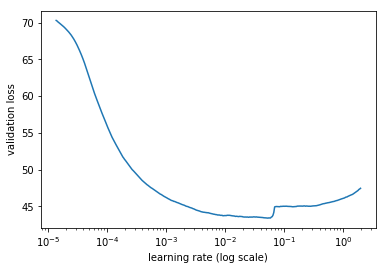

In [33]:
learn.lr_find()
learn.sched.plot()

In [34]:
lr=1e-3
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))
### 3x1 ###

# Baseline/resnet34
# 8.734978   8.446969   0.4503        1st run
# 4.518683   5.667496   0.325         2nd run   ~4:33   ***'baseline_64'

# Xception
# 14.47861   15.890462  0.617867      train head only
# 3.729286   5.795456   0.309467      full train    ~6min   ***'Xception'

epoch      trn_loss   val_loss   word_error_rate            
    0      34.735026  33.433831  0.682724  
    1      21.981151  19.860642  0.544686                   
    2      14.097778  12.228005  0.412971                   
    3      10.00395   8.780521   0.323695                   


[8.780520731608073, 0.3236952380952379]

In [66]:
learn.save('baseline_64')

## 128

 74%|███████▍  | 316/425 [01:03<00:21,  4.99it/s, loss=83.3]

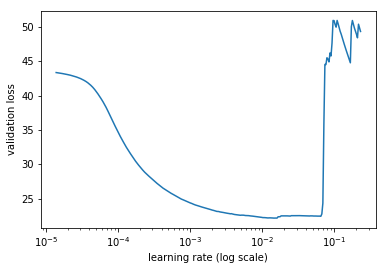

In [75]:
learn.lr_find()
learn.sched.plot()

In [73]:
lr=1e-3
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))

### 3x1 ###        # NOTE: progressive resizing does not work for baseline models!
# baseline/resnet34
# 6.36442    5.812      0.312833   ~6:21
# 2.524736   2.792402   0.155367   ***'baseline_128'

# resnet/non-seq attn
# 9.289723   8.815089   0.433567   ~6:08   em_sz: 256  
# 3.744278   3.886602   0.224367   ***'resnet_non_seq_attn'

# 9.871726   9.367488   0.445833   ~6:13   em_sz: 256; modified attn

# 15.713455  14.824469  0.568667   ~7:00   em_sz: 512
# 11.88506   11.737053  0.5238     ~5:10   em_sz: 128


# Xception
# 2.569643   2.696145   0.1458     ~10:25  ***'Xception_128'

### 3x2 ###
# baseline/resnet34
# 13.093655  11.400538  0.404133   ~9:34

# Xception
# 10.00395   8.780521   0.323695   ~12:07
# 3.41639    4.657719   0.173257   ***'Xception_3x2_128'

epoch      trn_loss   val_loss   word_error_rate            
    0      20.256063  20.115549  0.649267  
    1      17.619363  17.332133  0.608667                   
    2      13.621887  13.145833  0.536967                   
    3      9.871726   9.367488   0.445833                   



[9.367488174438476, 0.44583333333333336]

In [40]:
learn.save('resnet_non_seq_attn')

## 256

epoch      trn_loss   val_loss   word_error_rate             
    0      397.422367 765.350072 1.092348  



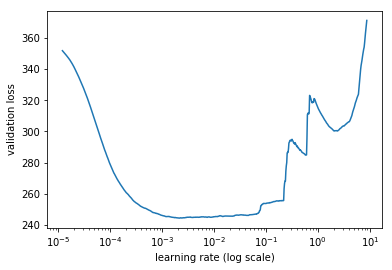

In [29]:
learn.lr_find()
learn.sched.plot()

In [32]:
lr=1e-3
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))

### 3x1 ###        # NOTE: progressive resizing does not work for baseline word models!


### 3x2 ###
# Xception
# 1.423656   1.311739   0.046114   ~46:30   seq_len: 8   ***'Xception_3x2_256'

### Large ###
# Xception
# 190.380608 186.346938 0.802406   ~38:04   seq_len: 40
# 133.599911 130.483274 0.713239   ***'Xception_large_256'

epoch      trn_loss   val_loss   word_error_rate             
    0      174.492905 169.158864 0.781746  
    1      159.587256 154.856296 0.761215                    
    2      146.749293 142.020836 0.738846                    
    3      133.599911 130.483274 0.713239                    



[130.4832735595703, 0.71323931061869]

In [34]:
learn.save('Xception_large_256')

# Train - Chars

## 64

In [24]:
lr=1e-3
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))

### 3x1 ###
# 60.088251  56.6687    0.64367      Arch
# 51.163667  48.662667  0.517828     2nd run
# 44.073406  43.868489  0.413981     3rd run    ***'experiment'

epoch      trn_loss   val_loss   char_error_rate            
    0      70.667268  69.891583  0.844056  



[69.89158327617342, 0.84405568607942]

## 128

In [110]:
learn.load('3x1_Xception_arch_128')

In [ ]:
lr=1e-3
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))

### 3x1 ###
# 50.904495  47.123982  0.4832       Arch, lr: 1e-3, sz: 128, emb: 256, 4cycles, clr=(20,4)
# 29.10461   26.629915  0.191563     2nd run
# 20.632274  21.7593    0.134349     3rd run    ***'3x1'

# 33.268777  30.922484  0.244573     ~14:10  Arch w/ Xception base   ***'3x1_Xception_arch_128'
# 26.414878  29.135453  0.207652     lr: 1e-4 -- Not training well!!

# (3x2)
# 114.570165 110.74643  0.670681

In [106]:
learn.save('3x1_Xception_arch_128')

## 256

In [111]:
sz = 256
bs = 60

In [114]:
learn.set_data(data)

 46%|████▌     | 324/709 [04:57<05:53,  1.09it/s, loss=106] 

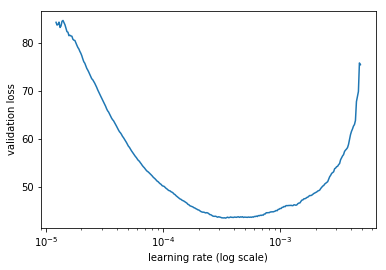

In [115]:
learn.lr_find()
learn.sched.plot()

In [124]:
lr = 1e-4
learn.fit(lr, 4, cycle_len=1, use_clr=(20,4))
# Note: preloading previous size to get these results

# 3x1  
# 16.319343  14.249333  0.082034      Arch, lr:1e-3, sz:256, emb:256, 4cycles, clr=(20,4)   ***'3x1_256'

# 22.207746  23.955643  0.145134      ~ 46:22   Xception Arch - preload 128
# 63.123368  60.420015  0.864963      ~ 20:00   Xception Arch - train from scratch; max_channels: 256    fail!!      

# 3x2
# 29.938486  29.298703  0.131659      Arch, lr:1e-4, sz:300, emb:256, 4cycles, clr=(20,4)   ***'3x2_300'

epoch      trn_loss   val_loss   char_error_rate             
    0      65.530962  61.158951  0.864044  
    1      64.610757  60.676768  0.864044                    
    2      63.67309   60.471426  0.868984                    
    3      63.123368  60.420015  0.864963                    


[60.4200146484375, 0.8649627958043364]

In [74]:
learn.save('3x2_300')

# Results

In [37]:
learn.load('3x2_300')

In [35]:
x,y = next(iter(data.val_dl))
learn.model.eval()
# preds,attns = learn.model(x, ret_attn=True)
preds = learn.model(x)
res = torch.argmax(preds, dim=-1)

seq2seq_loss(preds, y)

tensor(113.7889, device='cuda:0', grad_fn=<DivBackward0>)

In [36]:
word_error_rate(preds,y)

0.7245871857272488

In [39]:
char_error_rate(preds,y)

0.13050852120380457

### Images

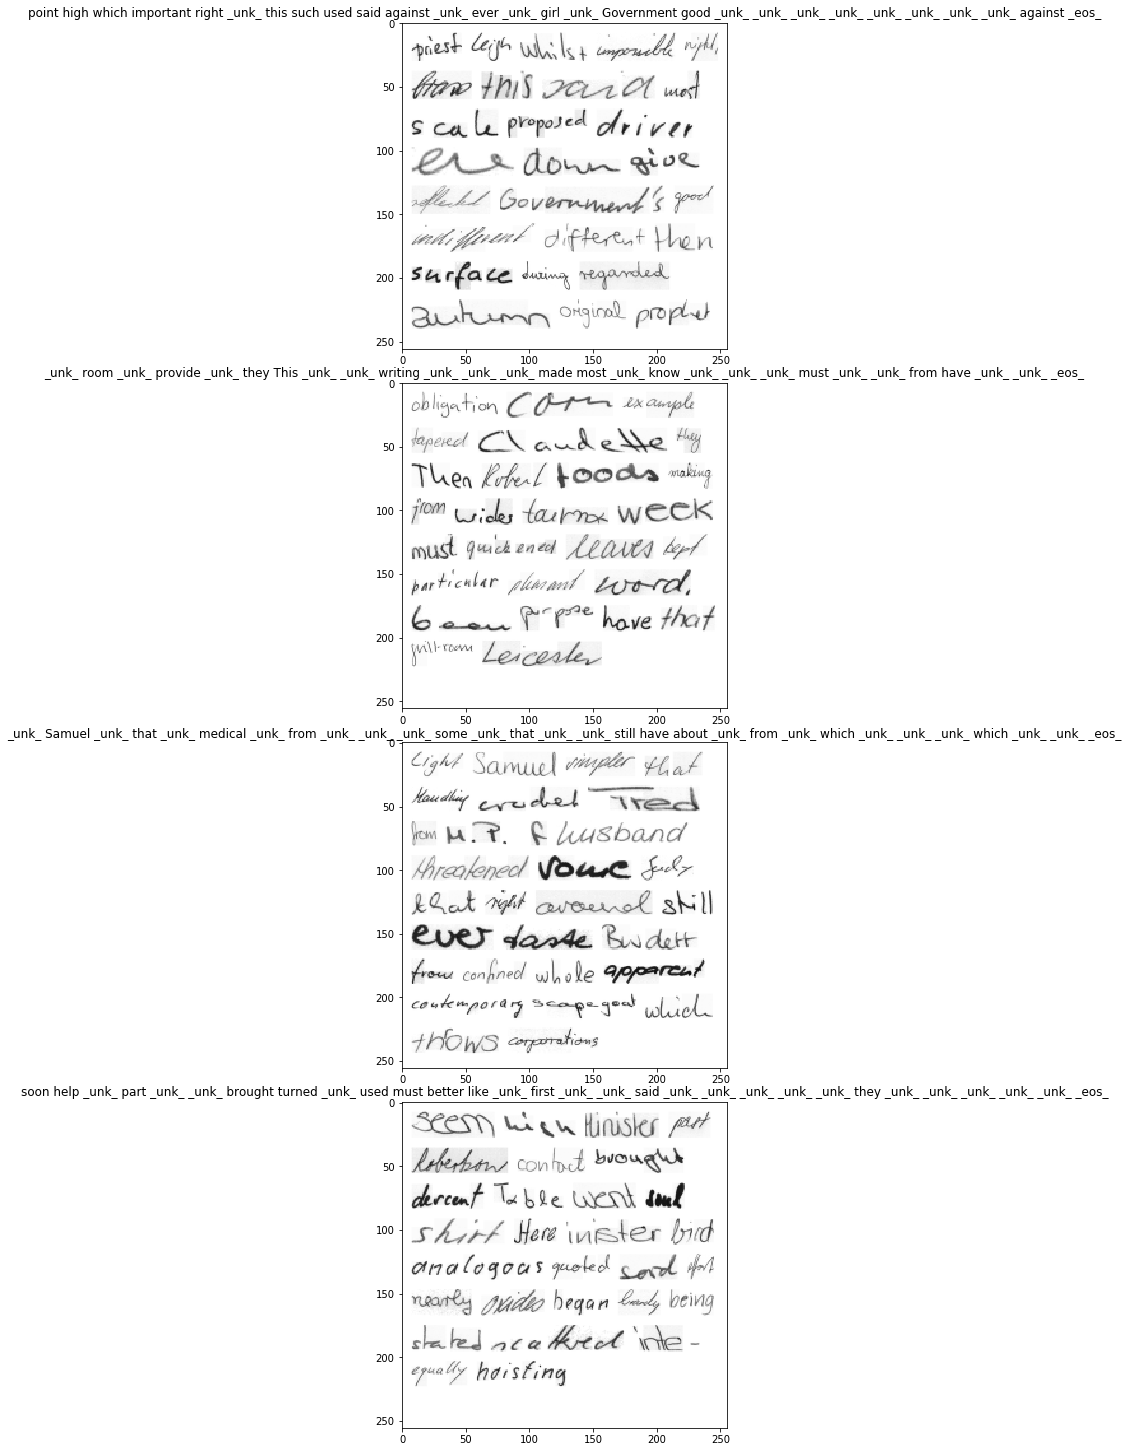

In [38]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,1, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    #t = char_label_text(y[i])     #=>  char indices
    p = word_label_text(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

### Attention

In [46]:
attns = attns.permute(1,0,2)

In [47]:
k = 16
def torch_scale_attns(attns):
    bs,sl,_ = attns.shape
    num = sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = torch.nn.functional.interpolate(mod, size=sz)
    return scaled  #([bs, sl, sz, sz])

In [48]:
from scipy.ndimage import gaussian_filter

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [56]:
idx  = 7
img  = imgs[idx]
pred = res[:,idx]
img_attns = to_np(torch_scale_attns(attns)[idx])

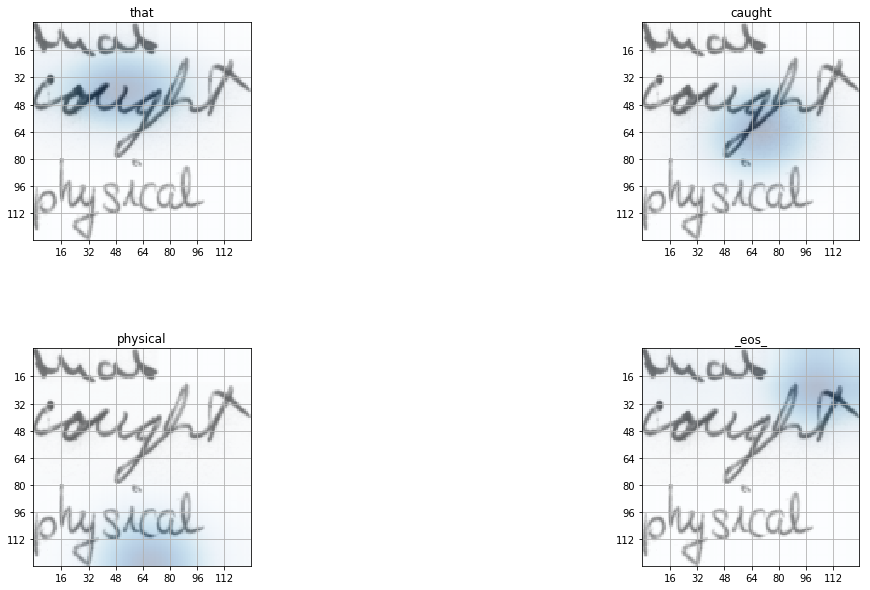

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'hspace': 0.5})
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

In [58]:
idx  = 6
img  = imgs[idx]
pred = res[:,idx]
img_attns = to_np(torch_scale_attns(attns)[idx])

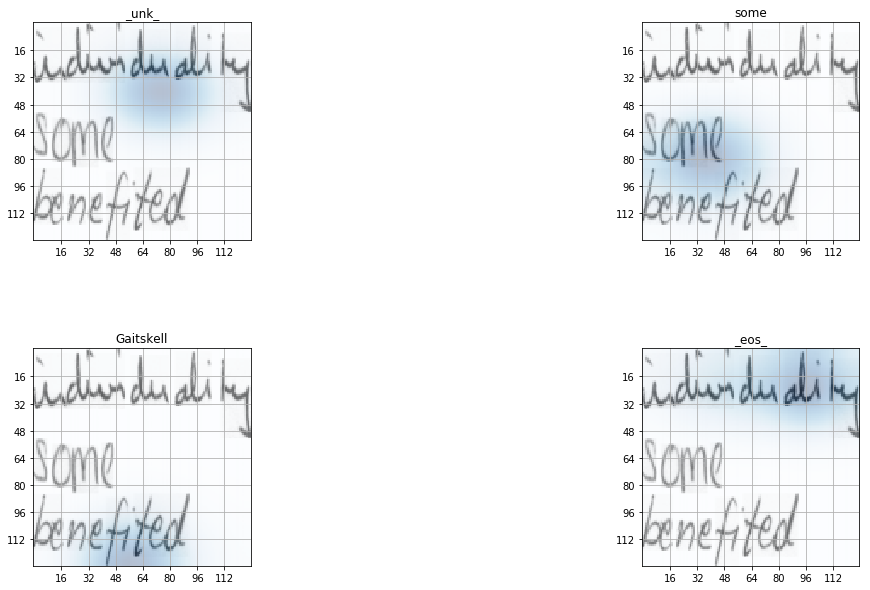

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'hspace': 0.5})
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(k, sz, k)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

# Beam Search

In [86]:
idx=12

In [87]:
prob = preds[:, idx]
amts, idxs = torch.topk(prob[0], 5)
amts, idxs

(tensor([-18.0286, -20.7020, -21.7893, -21.8339, -22.1800],
        device='cuda:0', grad_fn=<TopkBackward>),
 tensor([  69,  121,    2, 1503,  456], device='cuda:0'))

In [88]:
[itos[i] for i in idxs]

['under', 'number', '_unk_', 'murder', 'winter']

In [77]:
word_stoi['deliberately']

3176